In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import re
from os.path import isfile

In [28]:
def depth_map_to_image(npz_file):
    data = np.load(npz_file)
    depth_map = data['x'].astype(np.float32)
    img = cv2.normalize(depth_map, depth_map, 0, 1, cv2.NORM_MINMAX)
    img = np.array(img * 255, dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.applyColorMap(img, cv2.COLORMAP_OCEAN)
    return img
def depth_map_to_cv2_img_from_matplotlib_img(matplotlib_img):
    img = cv2.normalize(matplotlib_img, matplotlib_img, 0, 1, cv2.NORM_MINMAX)
    img = np.array(img * 255, dtype=np.uint8)
    return img
def show_depth_image_from_npz_file(npz_file):
    ocean = depth_map_to_image(npz_file)
    cv2.imshow("Image",ocean)
    cv2.waitKey( 0 )

In [29]:
def depth_map_to_image_matplotlib_compatible(npz_file):
    data = np.load(npz_file)
    depth_map = data['x'].astype(np.float32)
    img = cv2.normalize(depth_map, depth_map, 0, 1, cv2.NORM_MINMAX)
    img = np.array(img * 255, dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.applyColorMap(img, cv2.COLORMAP_OCEAN)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
def show_depth_image_from_npz_file_matplotlib_compatible(npz_file):
    ocean = depth_map_to_image_matplotlib_compatible(npz_file)
    plt.imshow(ocean, cmap='gray')

In [30]:
potential_files = os.listdir("pac_data/02/0")
depth_images = [f for f in potential_files if isfile("pac_data/02/0/" + f)]

In [31]:
date_to_images_dict = {}
for img in depth_images:
    current_date = img.split("_")[0]
    if not current_date in date_to_images_dict.keys():
        date_to_images_dict[current_date] = []
        date_to_images_dict[current_date].append(img)
    else:
        date_to_images_dict[current_date].append(img)

In [32]:
print(len(date_to_images_dict['20170106']))

1134


In [33]:
background_object = cv2.createBackgroundSubtractorMOG2(varThreshold=1000)

In [34]:
def interpolation_nearest_neighbor_helper(y, x, data_matrix):
    squared_distance_to_closest_point = float("inf")
    y_of_closest_non_zero_value_so_far = None
    x_of_closest_non_zero_value_so_far = None
    window_size = 3
    while(y_of_closest_non_zero_value_so_far == None and x_of_closest_non_zero_value_so_far == None):
        w = window_size // 2
        deltay = range(-1 * w, w+1)
        deltax = range(-1 * w, w+1)
        for dy in deltay:
            for dx in deltax:
                if y+dy < len(data_matrix) and x+dx < len(data_matrix[0]):
                    if data_matrix[y+dy][x+dx] > 0.001:
                        current_squared_distance = ((y+dy)**2) + ((x+dx)**2)
                        if (y_of_closest_non_zero_value_so_far == None and x_of_closest_non_zero_value_so_far == None):
                            squared_distance_to_closest_point = current_squared_distance
                            y_of_closest_non_zero_value_so_far = y+dy 
                            x_of_closest_non_zero_value_so_far = x+dx
                        else:
                            if current_squared_distance <  squared_distance_to_closest_point:
                                y_of_closest_non_zero_value_so_far = y+dy
                                x_of_closest_non_zero_value_so_far = x+dx
        window_size += 2
    return y_of_closest_non_zero_value_so_far, x_of_closest_non_zero_value_so_far
                        
def interpolation_nearest_neighbor(data_matrix):
    final_result = np.copy(data_matrix)
    for r in range(len(data_matrix)):
        for c in range(len(data_matrix[0])):
            if data_matrix[r][c] < 0.001:
                newR, newC = interpolation_nearest_neighbor_helper(r, c, data_matrix)
                final_result[r][c] = data_matrix[newR][newC]
    return final_result

In [35]:
fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold=100)

In [53]:
from skimage import filters
from skimage.feature import corner_harris, corner_peaks
from scipy import ndimage
from skimage.filters import threshold_otsu, threshold_local
from skimage import feature
import numpy as np

data1 = np.load("pac_data/02/0/20160930_082811_796.npz")
img1 = data1['x'].astype(np.float32)
img_med1 = ndimage.median_filter(img1, 4)
#block_size = 25
#binary_adaptive = threshold_local(img1, block_size, offset=10)
binary_mask_temp = img_med1 > 0.1
img_med1[binary_mask_temp==0] = (np.sum(img_med1) * 1.0) / (240.0 * 320.0)
img_med1 = ndimage.median_filter(img_med1, 4)
#cv2_normalized_img_gray_scale_1 = depth_map_to_cv2_img_from_matplotlib_img(img_med1)
#foreground1 = fgbg.apply(cv2_normalized_img_gray_scale_1)

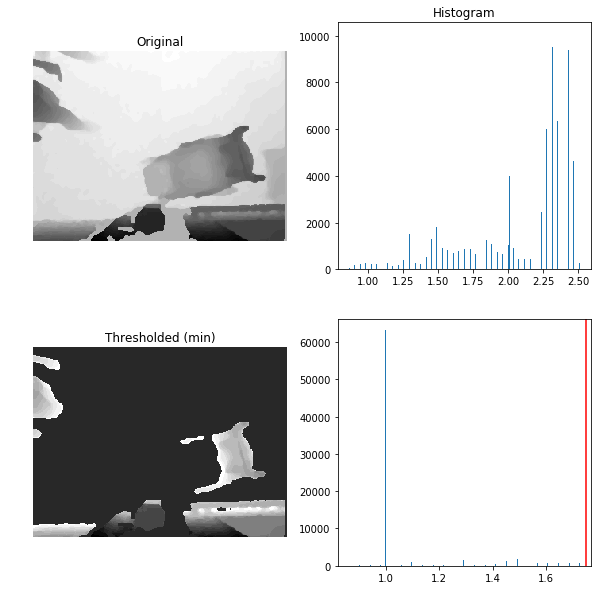

In [54]:
from skimage.filters import threshold_minimum

thresh_min = threshold_minimum(img_med1)
thresh_min = 1.75
binary_min = img_med1 < thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(img_med1, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(img_med1.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

img_med1[binary_min==0] = 1 
ax[1, 0].imshow(img_med1, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(img_med1.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

In [26]:
data1 = np.load("pac_data/02/1/20160930_084735_699.npz")
img1 = data1['x'].astype(np.float32)
print(len(img1))
print(len(img1[0]))
img_med1 = ndimage.median_filter(img1, 4)
#block_size = 25
#binary_adaptive = threshold_local(img1, block_size, offset=10)
cv2_normalized_img_gray_scale_1 = depth_map_to_cv2_img_from_matplotlib_img(img_med1)
foreground1 = fgbg.apply(cv2_normalized_img_gray_scale_1)

240
320


[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
0.8
[[0.9688716 0.9688716 0.9688716 ... 0.        0.        0.       ]
 [0.9688716 0.9688716 0.9688716 ... 0.        0.        0.       ]
 [0.9688716 0.9688716 0.9688716 ... 0.        0.        0.       ]
 ...
 [0.5782101 0.5782101 0.5782101 ... 0.015625  0.015625  0.015625 ]
 [0.5626459 0.5626459 0.5626459 ... 0.015625  0.        0.       ]
 [0.5466926 0.5466926 0.5466926 ... 0.015625  0.        0.       ]]


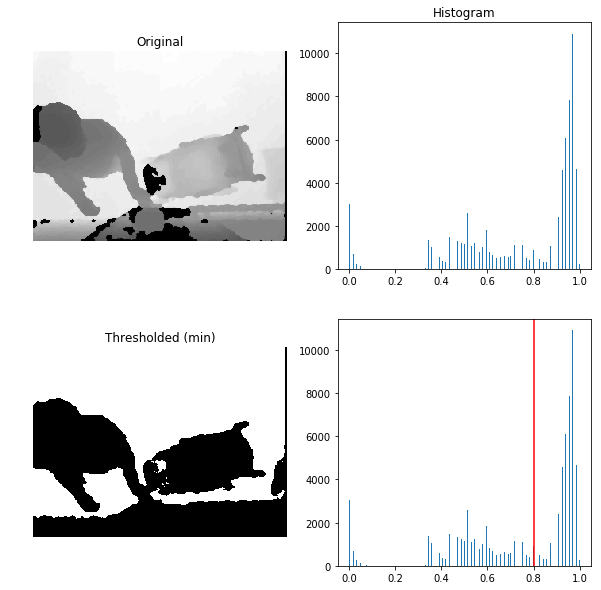

In [24]:
from skimage.filters import threshold_minimum

thresh_min = threshold_minimum(img_med1)
thresh_min = 0.8
binary_min = img_med1 > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(img_med1, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(img_med1.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')
print(binary_min)

ax[1, 1].hist(img_med1.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')
print(thresh_min)
print(img_med1)

for a in ax[:, 0]:
    a.axis('off')
plt.show()

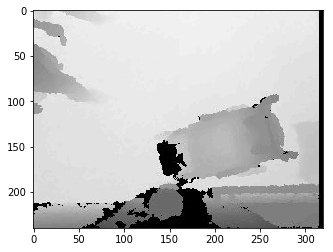

In [18]:
plt.imshow(img1, cmap=plt.cm.gray)

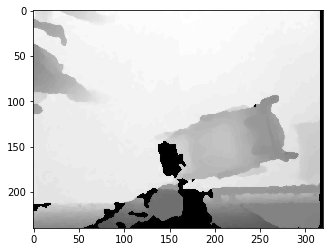

In [31]:
plt.imshow(img_med1, cmap=plt.cm.gray)

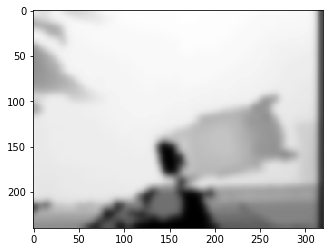

In [32]:
plt.imshow(binary_adaptive, cmap=plt.cm.gray)

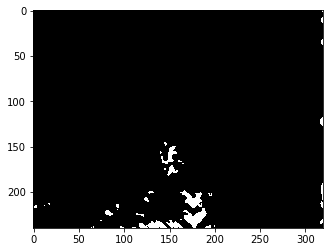

In [13]:
plt.imshow(foreground1, cmap=plt.cm.gray)

In [14]:
print(foreground1)

[[127 127 127 ... 127 127 255]
 [127 127 127 ... 127 127 255]
 [127 127 127 ... 127 127 127]
 ...
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]
 [127 127 127 ... 127 127 127]]


In [15]:
data2 = np.load("pac_data/02/0/20160930_082811_996.npz")
img2 = data2['x'].astype(np.float32)
img_interpolated2 = interpolation_nearest_neighbor(img2)
img_med2 = ndimage.median_filter(img_interpolated2, 4)
cv2_normalized_img_gray_scale_2 = depth_map_to_cv2_img_from_matplotlib_img(img_med2)
foreground2 = fgbg.apply(cv2_normalized_img_gray_scale_2)

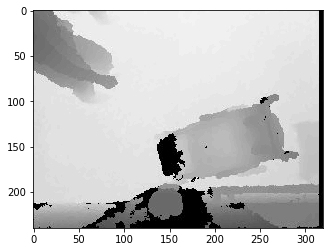

In [16]:
plt.imshow(img2, cmap=plt.cm.gray)

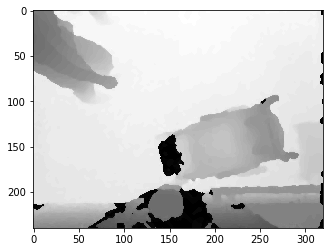

In [17]:
plt.imshow(img_med2, cmap=plt.cm.gray)

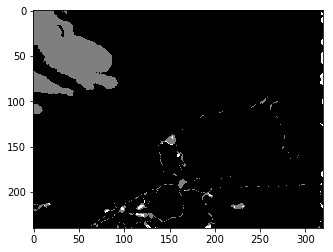

In [18]:
plt.imshow(foreground2, cmap=plt.cm.gray)

In [19]:
print(foreground2)

[[127 127 127 ...   0   0   0]
 [127 127 127 ...   0   0   0]
 [127 127 127 ...   0 255   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [20]:
data3 = np.load("pac_data/02/0/20160930_082812_197.npz")
img3 = data3['x'].astype(np.float32)
img_interpolated3 = interpolation_nearest_neighbor(img3)
img_med3 = ndimage.median_filter(img_interpolated3, 4)
cv2_normalized_img_gray_scale_3 = depth_map_to_cv2_img_from_matplotlib_img(img_med3)
foreground3 = fgbg.apply(cv2_normalized_img_gray_scale_3)

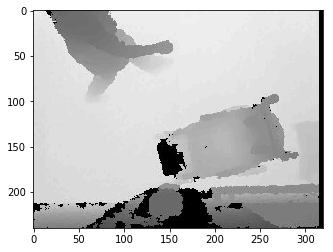

In [21]:
plt.imshow(img3, cmap=plt.cm.gray)

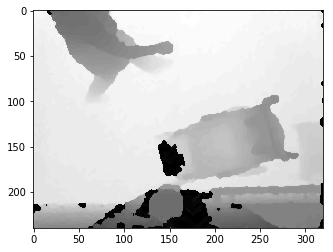

In [22]:
plt.imshow(img_med3, cmap=plt.cm.gray)

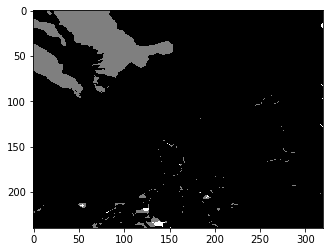

In [23]:
plt.imshow(foreground3, cmap=plt.cm.gray)

In [24]:
print(foreground3)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [25]:
data4 = np.load("pac_data/02/0/20160930_082812_464.npz")
img4 = data4['x'].astype(np.float32)
img_interpolated4 = interpolation_nearest_neighbor(img4)
img_med4 = ndimage.median_filter(img_interpolated4, 4)
cv2_normalized_img_gray_scale_4 = depth_map_to_cv2_img_from_matplotlib_img(img_med4)
foreground4 = fgbg.apply(cv2_normalized_img_gray_scale_4)

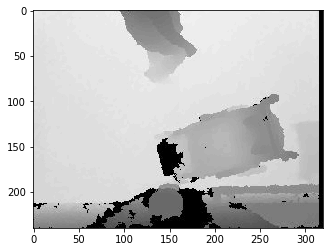

In [26]:
plt.imshow(img4, cmap=plt.cm.gray)

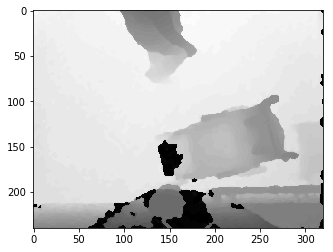

In [27]:
plt.imshow(img_med4, cmap=plt.cm.gray)

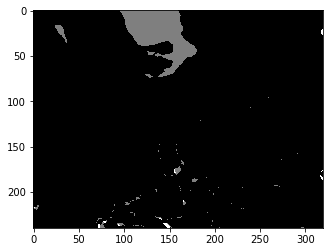

In [28]:
plt.imshow(foreground4, cmap=plt.cm.gray)

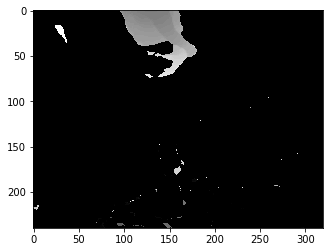

In [29]:
img_med4[foreground4 == 0] = 0
plt.imshow(img_med4, cmap=plt.cm.gray)

In [30]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(img_med4)
img_binary1 = img_med4 > thresh

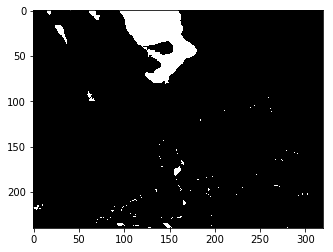

In [32]:
plt.imshow(img_binary1, cmap=plt.cm.gray)

In [19]:
img_canny_edged = feature.canny(img_med1, sigma=3)

/Users/emanuelcortes/Documents/Senior_Year/Winter_Quarter_2018/CS199/.env/lib/python3.5/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


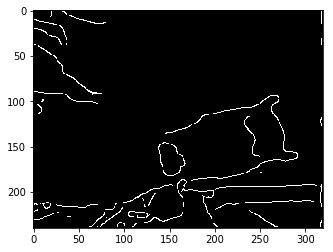

In [20]:
plt.imshow(img_canny_edged, cmap=plt.cm.gray)

In [34]:
from scipy import ndimage as ndi
label_objects, nb_labels = ndi.label(img_canny_edged)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 5
mask_sizes[0] = 0
img_canny_edged_cleaned = mask_sizes[label_objects]

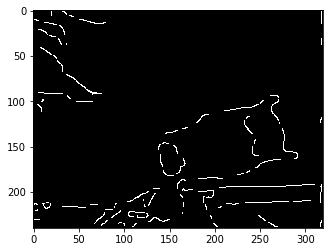

In [35]:
plt.imshow(img_canny_edged_cleaned, cmap=plt.cm.gray)

In [36]:
filled_img_canny_edged_cleaned = ndi.binary_fill_holes(img_canny_edged_cleaned)

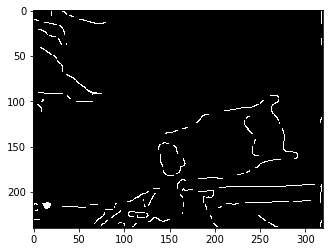

In [37]:
plt.imshow(filled_img_canny_edged_cleaned, cmap=plt.cm.gray)